# Project1: Particle identification in Liquid Argon Time Projection Chambers

<img src="http://deeplearnphysics.org/DataChallenge/static/images/Entry078_data.png" alt="TPC3D" style="width: 400px;"/>

## Introduction

---

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Data Scientist (n.): Person who is better at statistics than any software engineer and better at software engineering than any statistician.</p>&mdash; Josh Wills (@josh_wills) <a href="https://twitter.com/josh_wills/status/198093512149958656?ref_src=twsrc%5Etfw">May 3, 2012</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

---
### Time Projection Chambers (TPC)
Liquid argon TPCs are a type of neutrino detector which aims at providing high-resolution 3D track reconstruction which can in principle provide unprecedented detail in neutrino event reconstruction.

Charged particles in liquid argon produce ionization electrons, which drift to the readout wire planes in an electric field of 273 V/cm. It takes 2.3 ms for an ionization electron to drift across the full width of the detector.
One such LArTPC detector is found in the MicroBooNE experiment. MicroBoone has been recording data since 2015, and continuously records charge drifted and its arrival time on each wire. 
As a charged particle passes through a medium, it will create ionisation. In a TPC, an electric field causes the produced electrons to drift to anode wires at the end of the vessel. The drift time and the position of the hit wire are combined to provide a 3D reconstruction of the event.

Wire and time data can be converted into an image format (charge on each wire versus drift time) while maintaining high resolution in wire, time and charge amplitude space. These information-rich
LArTPC images are suitable for applying deep learning tools.


### Example of first images from MicroBooNE experiment
Liquid argon TPCs are ideal for neutrino experiments because they provide a relatively large target mass (unlike gas TPCs, which by their nature have relatively low densities). Neutrino interactions with LAr nuclei can result in several distinc signatures, such as a proton (p) and electron (e) being produced at a vertex point ([images from 2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841)):

<img src="https://inspirehep.net/files/cba430719ebf8bcb922cda5f98cb9824" alt="MicroBooNE" style="width: 300px;"/> 

a proton, electron and photon (y) being produced from a vertex point. The photon flies through the material undetected and converts to a electron and positron pair ([pair production](https://en.wikipedia.org/wiki/Pair_production)) creating an electromagnetic shower.

<img src="https://inspirehep.net/files/619950f112f0d77089e97134025c6d4e" alt="MicroBooNE" style="width: 300px;"/> 

a proton and muon:

<img src="https://inspirehep.net/files/9fe207573f051203a98987930e7a56c1" alt="MicroBooNE" style="width: 300px;"/> 

and many other topologies. Classification of particles within the detector volume is therefore vital to being able to detect and measure neutrino collisions. You can read up on how MicroBooNE designed a convolutional neural network to identify images at [2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841), which may serve as inpiration for your own CNNs.

## TPC DATASET
We will be using the open dataset from [deeplearningphysics.org](http://deeplearnphysics.org/DataChallenge/), which consists of liquid argon time projection chamber (LArTPC) simulated data. There are some great resources in terms of [Tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html#tutorial_summary) which describe the data, though the code that is used there is not applicable here directly.

The subset of the dataset used are 90K in total simulated events for the purpouse of particle classification. Unlike the images we see above, the events here only have one particle in them, for the purpouse of doing particle by particle classification.

Each event contains 3 projected images on the XY, YZ, and ZX planes.
Each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. 

### Example 
Three 2D projected images from an event of a simulated electron. Blue colors are lower pixel intensity, meaning little to no ionisation capture, while red pixels are hot, meaning high ionisation. The point where the true particle is produced is marked with an X is taken from the truth information.

![panes](https://cernbox.cern.ch/index.php/s/ulFmgU3nAjw9X8i/download)

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last
import scipy.sparse as sparse



---
### The image dataset

You can download the datasets from [this folder](https://cernbox.cern.ch/index.php/s/qk8uZgYlg7VubRi). You need both `LArTPC_images_90k.npz` and `LArTPC_truth_90k.npy`

In [3]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images),images.shape,np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 514850816


**Note on image data**

The data has been pre-prepared and loaded as **sparse matrices**. We use this special format since each image has `(256x256x3)= ` 197 thousand pixels. Loading the entire 90'000 images in a **dense matrix** (every value filled) to RAM would be **17 billion pixels and over 30GB** of nessesary RAM!

However, since we have lots and lots of 0s in the images, which are largely empty except for pixels with particle activity, we can ignore the 0s with a sparce representation of the data, by keeping track of the index of the active pixels.


In [4]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

With our sparse representation we only load **66 million active pixels** and their indexes (positions), which only take up around **500 MB**! 

Notice that our data images are flattened to 196608 pixels from the original (256,256,3). This is because sparce matrices only support two dimensional matrices. To get back our original image we need to reshape the image back.

Here is a function to retrive the original 3 images in the XY, YZ and ZX planes

**IMPORTANT:** Converting the images this way requires conversion to dense matrix, meaning the zeros are reintreduced. Hece we should only do this on a few events! 

In [5]:
def toimage(sparsearray):
    #Convert to dense array, and reshape to three 2D images
    reshape = sparsearray.toarray().reshape((256,256,3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

Lets grab the 1st particle and retrieve the images using the `jet` color map.



In [6]:
XY,YZ,ZX = toimage(images[0])

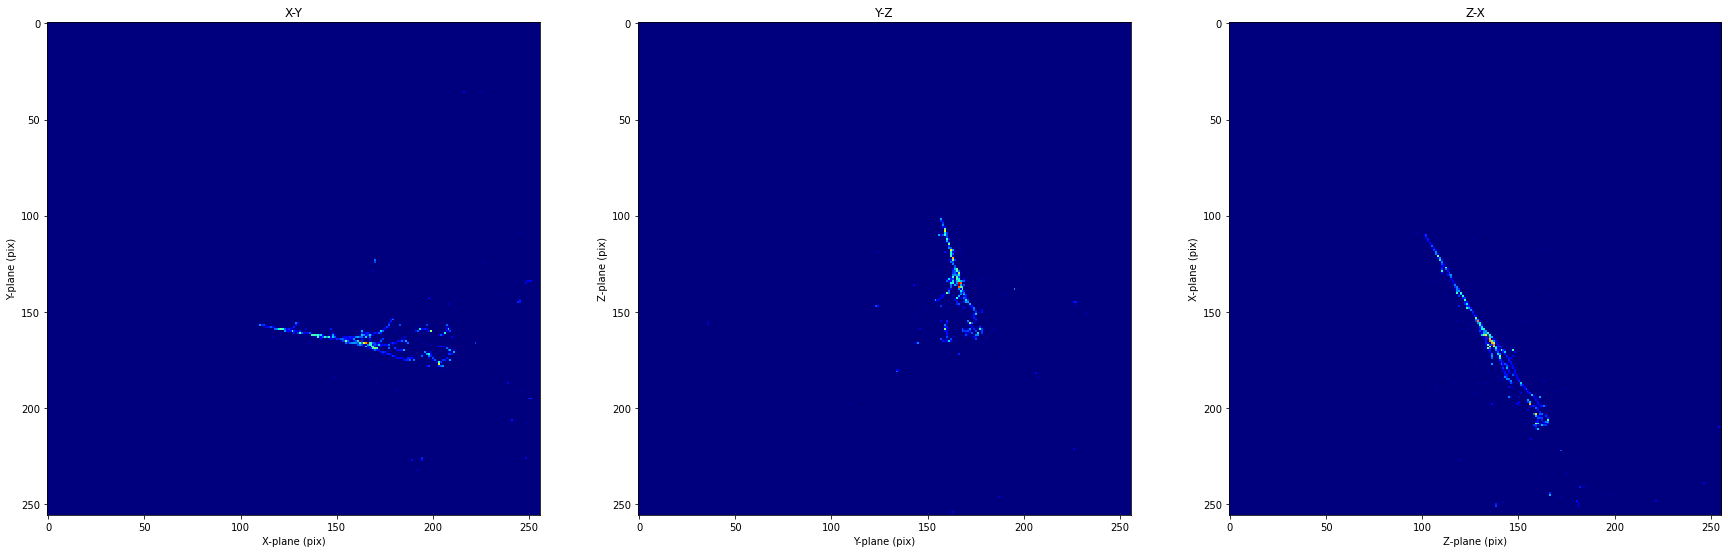

In [7]:
labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(images[0])
fig = plt.figure(figsize=(30,10))

for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title(labels[index])
fig.savefig("lar_planes.png")

---
### Truth information

Real data in a neutrino experiment does not come with labels, but since our dataset is simulated, we have the **truth level information** of the particles. We load the truth dataset here.

In [8]:
truth = np.load("LArTPC_truth_90k.npy")

We have eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [9]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z= (truth[:,i] for i in range(truth.shape[1]))

In [10]:
truth.shape

(90000, 8)

# Project

For the project are required to perform an in depth investigation of the image dataset, and design **two** machine learning techniques from the dataset. The first tasks are **compulsary** where you are required explore the data and create an algorithm to identify/classify the particle in each event.  

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

To complete this project, you should:
* Perform **Task 0 and 1** and an additional task from **Task 2** (but not necessarily restricted to just these), label/number your studies, discuss the results, and compare their relative merits.
    * If you do any neat studies that don't result in a classification variable, _e.g._ image generation, that still very much counts!
* **Submit your Jupyter notebook** as a "report." See the comments below on documentation,
    
When doing each of your studies, you should try to follow the below steps (where it makes sense; rough weight in marking indicated in parentheses):

1. **Data exploration and preprocessing (10%):** Inspect the datasets; visualise the data in an appropriate way; study the composition of the dataset; perform any necessary preprocessing.
2. **Model selection (30%):** Choose a promising approach; construct the machine learning model; optimise the relevant hyperparameters; train your chosen model.
3. **Performance evaluation (20%):** Evaluate the model in a way that gauges its ability to generalise to unseen data; compare to other approaches; identify the best approach. 
4. **Discussion, style throughout (40%):** Discuss the reasoning or intuition behind your choices; the results you obtain through your studies; the relative merits of the methods you have developed, _etc._ Similarly, make sure that you write efficient code, document your work, clearly convey your results, and convince us that you have mastered the material.


That is, **you should submit, by Friday 3rd December 2020 at 4pm:**
* your report notebook via Turnitin.
    

For all task we're not looking for exceptional performace and high scores (although those are nice too), **we're mostly concerned with _best practices:_** If you are careful and deliberate in your work, and show us that you can use the tools introduced in the course so far, we're happy!

Training all of these models in sequence takes a very long time so **don't spend hours on training hundreds of epochs.** Be conservative on epoch numbers (30 is more than enough) and use appropiate techniques like EarlyStopping to speed things up.



### Documentation

Your reportnotebook should run without errors and give (mostly) reproducible results. It is important that **all** code is annotated and that you provide brief commentary **at each step** to explain your approach. Explain *why* you chose a given approach and *discuss* the results. You can also include any failed approaches if you provide reasonable explanation; we care more about you making an effort and showing that you understand the core concepts.

This is not in the form of a written report so do not provide pages of background material, but do try to clearly present your work so that the markers can easily follow your reasoning and can reproduce each of the steps through your analysis. Aim to convince us that you have understood the material covered in the course.

To add commentary above (or below) a code snippet create a new cell and add your text in "Markdown" format. Do not add any substantial commentary as a code comment in the same cell as the code. To change the new cell into markdown select from the drop down menu on the bar above the main window (the default is code)

---
# Lets get started

We need to define a few more things as we get started, but lets first split the data into 50K for training, and 40K reserved for testing

In [11]:
from sklearn.model_selection import train_test_split 

In [12]:
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=50000,random_state=11)

## Special notes for traning on sparse matrices

Since we are using sparce matrices instead of dense ones, we need to tweak the way we **train**, **evaluate**, and **predict** from our model. This is because each of these steps requires the data to be **dense**, and we will run into the previous mentioned memory issues very quickly.


The solution for this is by using a **data generator** which will only load the dense data in batches. I give the function below.

The `nn_batch_generator` takes in the input data `X_data`, labels `y_data` and `batch_size` and creates a mini dense batch based on the `batch_size`. The `yield` keyword is a type of `return` function but which allows the method to keep running. Since we usually train on small batches (e.g. `32` events per batch) the data should be able to fit in memory.

In [13]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0


Below is an example of passing the generator itself into the fit method. Because the generator would run forever, we need to use the `steps_per_epoch` parameter to tell the training when to stop (i.e, it reached the end of the data). We therefore set `steps_per_epoch` to the number of training entries divided by the batch size. In this case I set 5000 entries aside for the validation set.

**Note these are just examples taken from my own notebooks so don't expect to just work out the box for you**
```
validation_slice=5000
batch_size=32
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-valdation_slice:], y_labels[-validation_slice:]))

```


Similarly predict and evaluate methods take generators with the `steps` parameter to end the evalutation

```
cnn.predict(nn_batch_generator(x_train[-5000:], y_train_labels[-5000:],batch_size=50),steps=5000/50)
```

```
cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)
```



### Finally a note on training 
We are training on a huge amount of data in practice, so expect the training to be **very very slow!!!**. I was clocking a single CNN training with 30 epochs at around 90 minutes on my CPU. I would recommend trying to run hyperparemer tests at night while you are sleeping, or alternatively if you must run from the CP labs, run them on a smaller set of 5K samples, with 500 validation. However, note that although the smaller trainings may allow you to explore different parameters more quickly, it won't nessesarily translate to the big dataset as easily, so at some point you will want to launch some big trainings on networks you find promissing. Remember to document your process as much as possible!

It is absolutely **essential** that you use callbacks to reduce the training time
* Use ReduceLROnPlateau if the training has not improved after a number of epochs
* Use EarlyStopping to exit the training if it has not improved after a number of epochs (should be a larger number than what is used on ReduceLROnPlateau)
* Use ModelCheckpoint to save the *best* model to a unique file. You can then use keras `load_model` (already imported for you) to load the saved model and not have to retrain if you close the notebook. Alternatively you can save any model with `save_model`.

In [14]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau



**If the project description is unclear, or if you experience any technical issues, please do let me know as quickly as possible. I can send around clarifications if I think it would be to the benefit of the entire class.**

---

**Your code below**

---

## Task 0

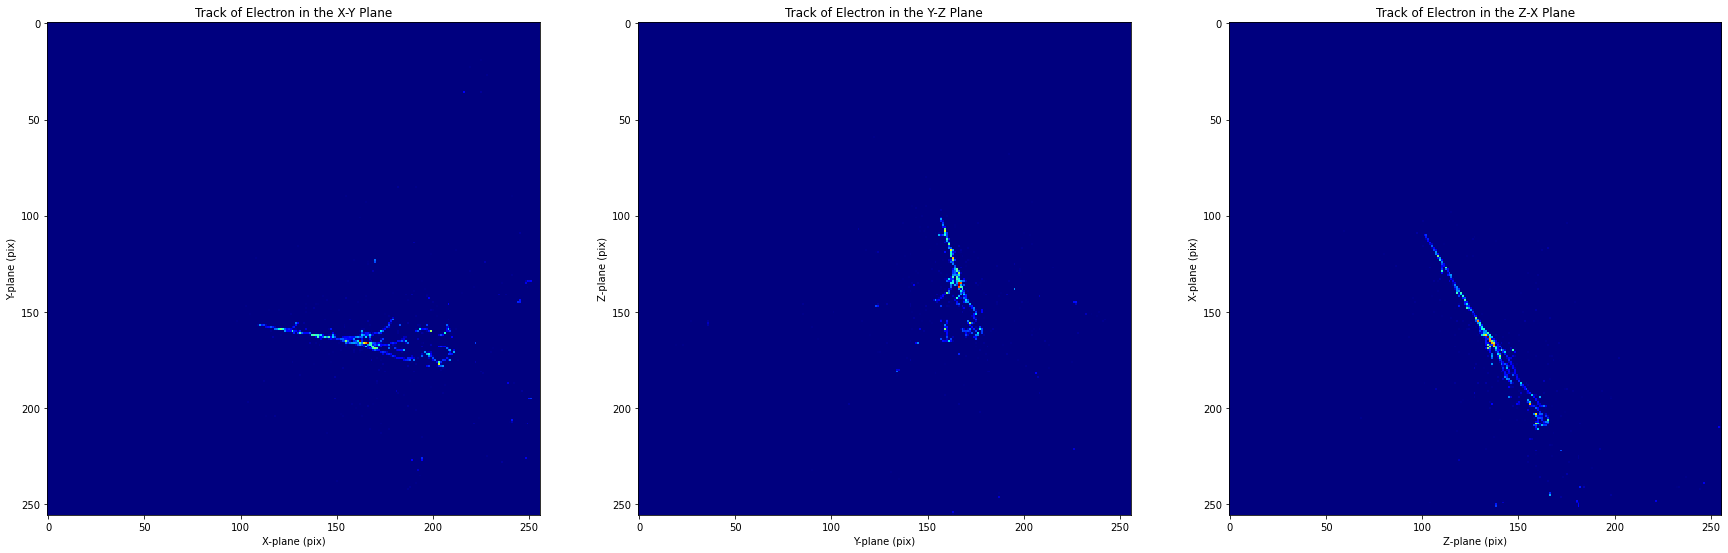

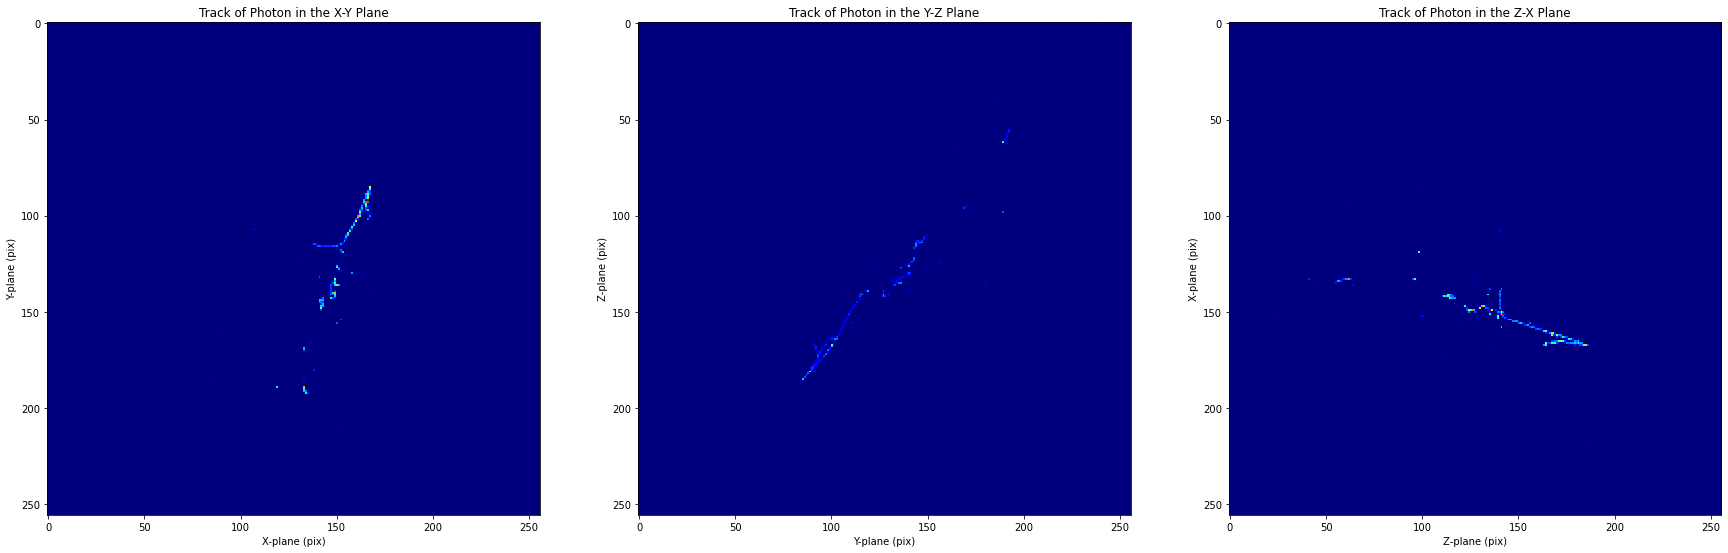

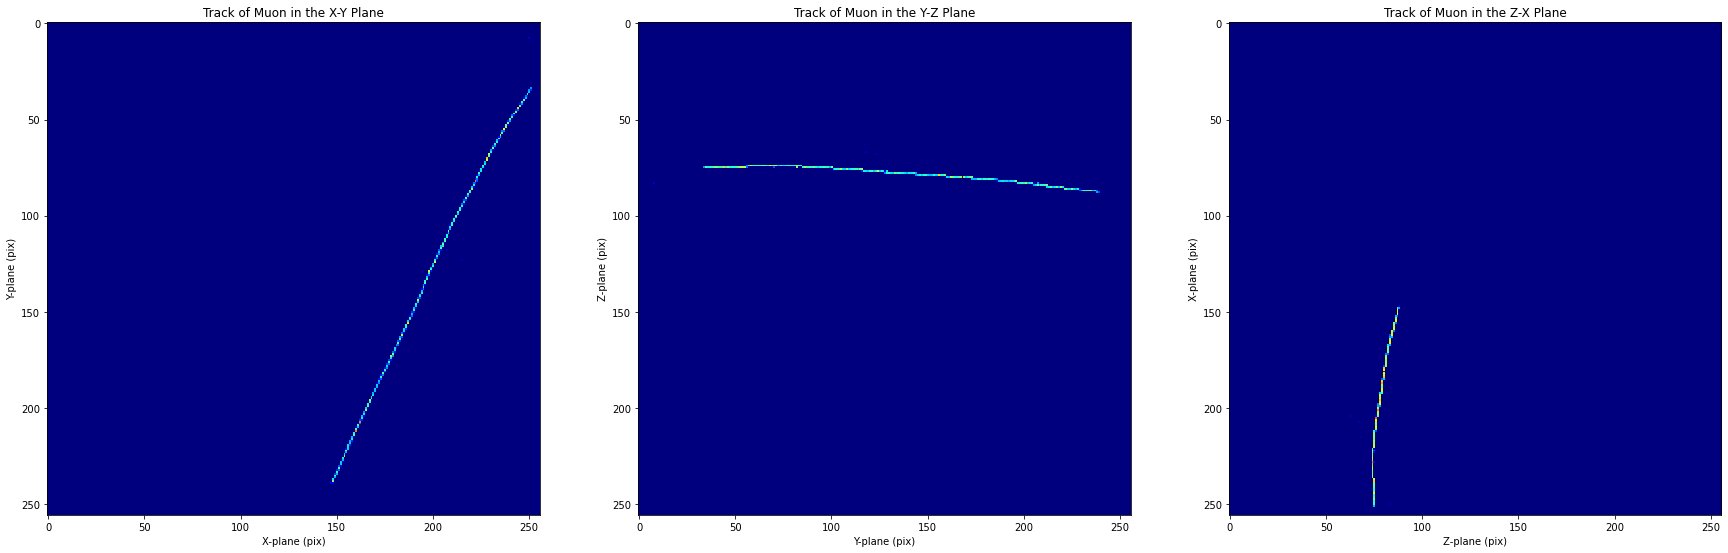

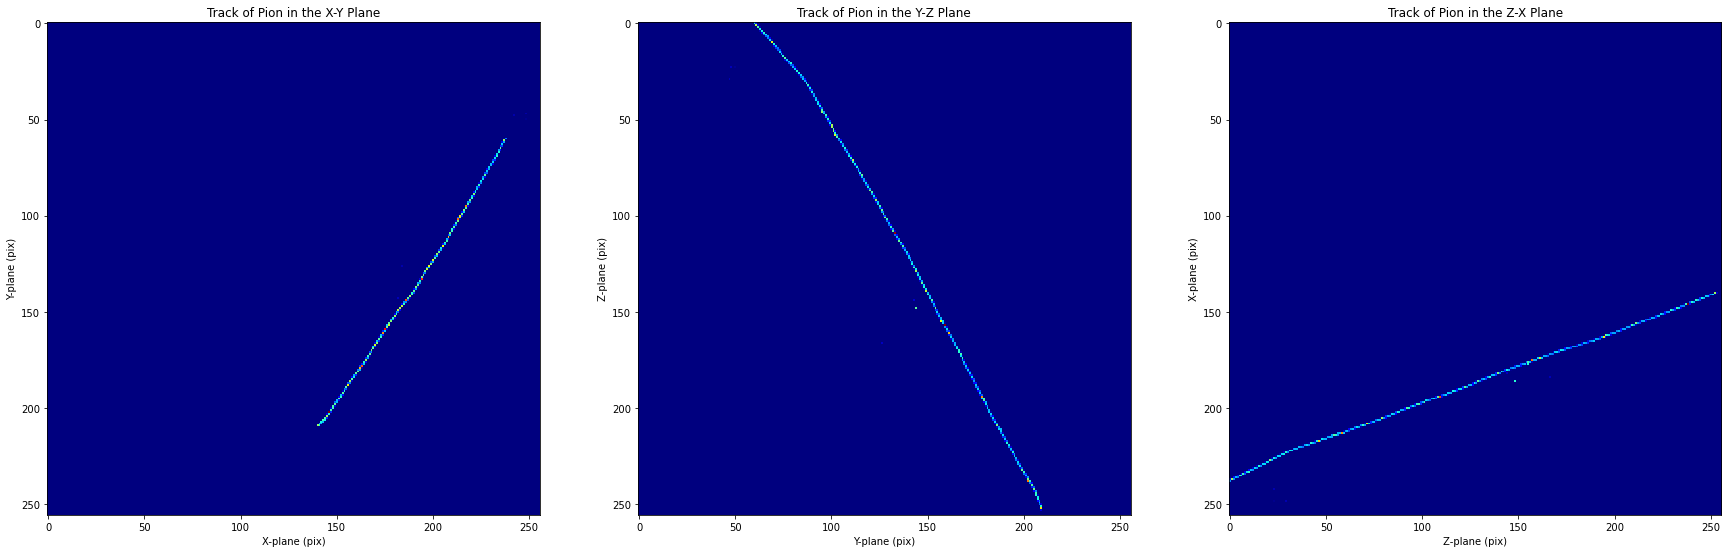

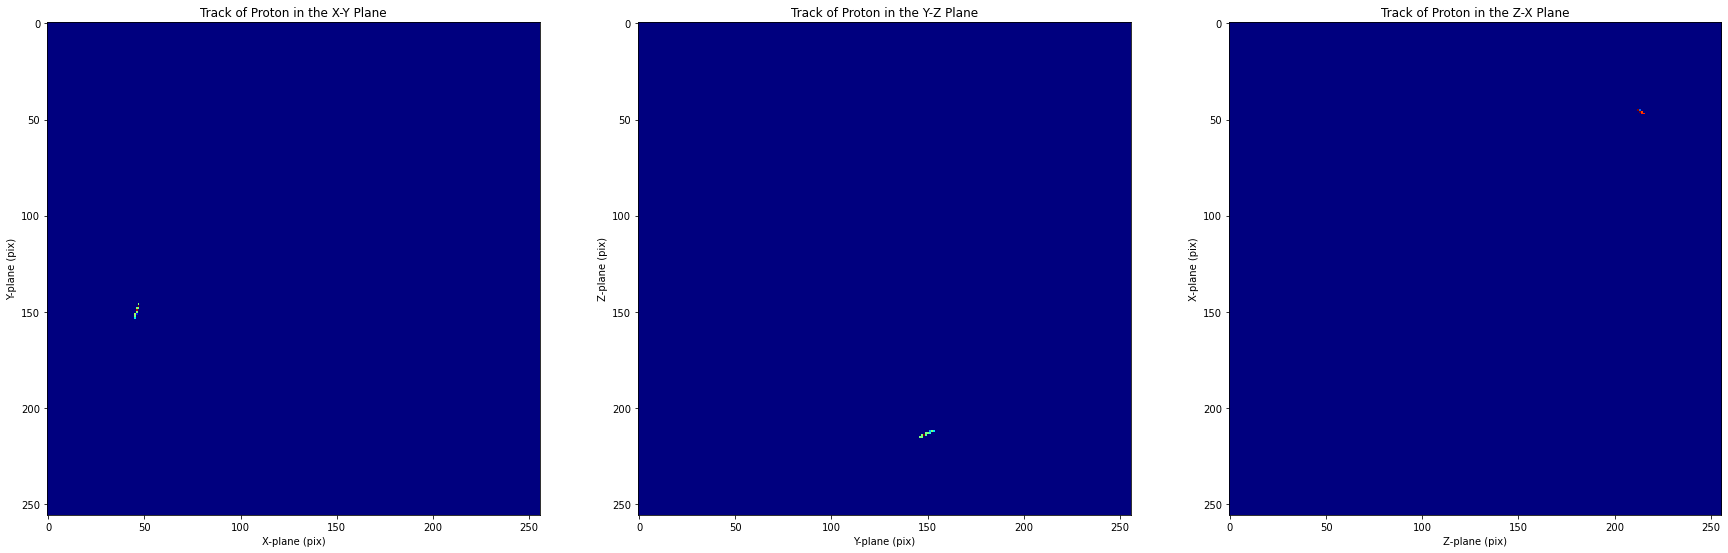

In [15]:
#Task 0 -- plotting different particles

electron = images[p_id==11]
photon = images[p_id==22]
muon = images[p_id==13]
pion = images[p_id==211]
proton = images[p_id==2212]
particles = [electron,photon,muon,pion,proton] # putting all particle images in a list
p_name = ['Electron','Photon','Muon','Pion','Proton']


for i in range(len(particles)):
    labels=["X-Y","Y-Z","Z-X"]
    ilist= toimage(particles[i][0])
    fig = plt.figure(figsize=(30,10))
    for index, image in enumerate(ilist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title("Track of "+str(p_name[i])+" in the "+str(labels[index])+" Plane")

plt.show()


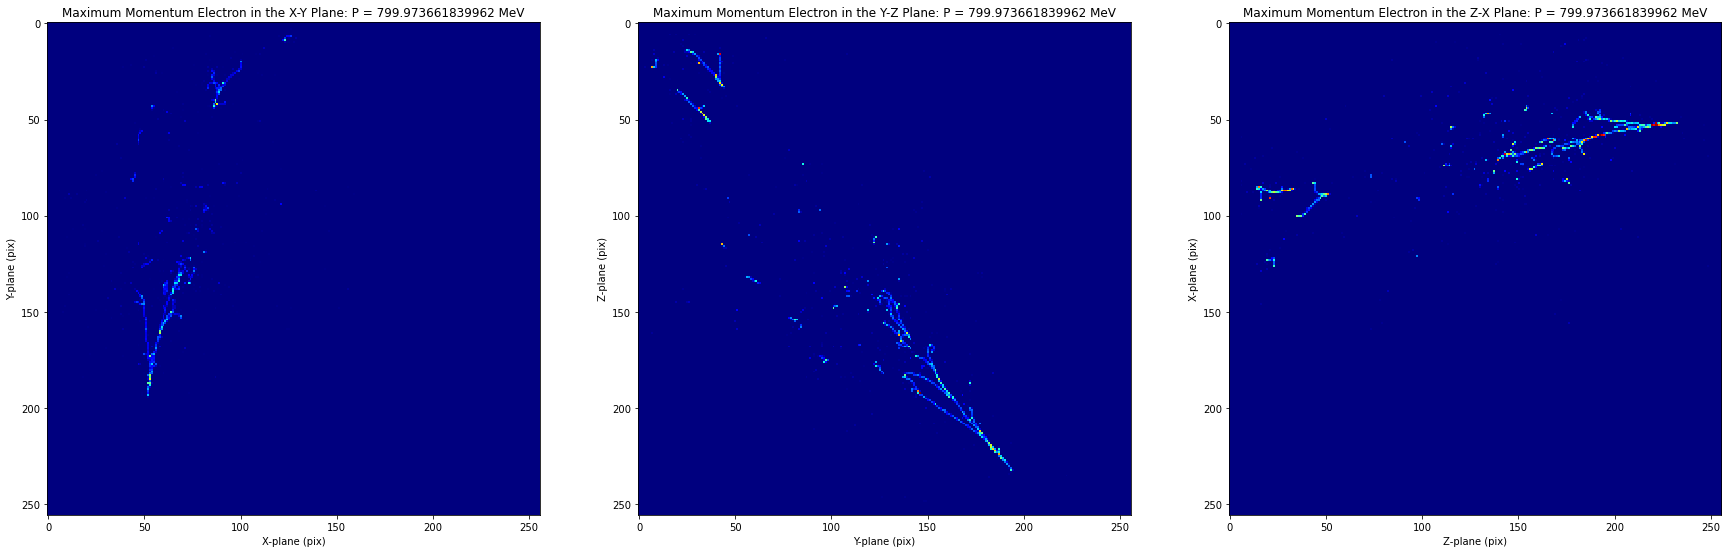

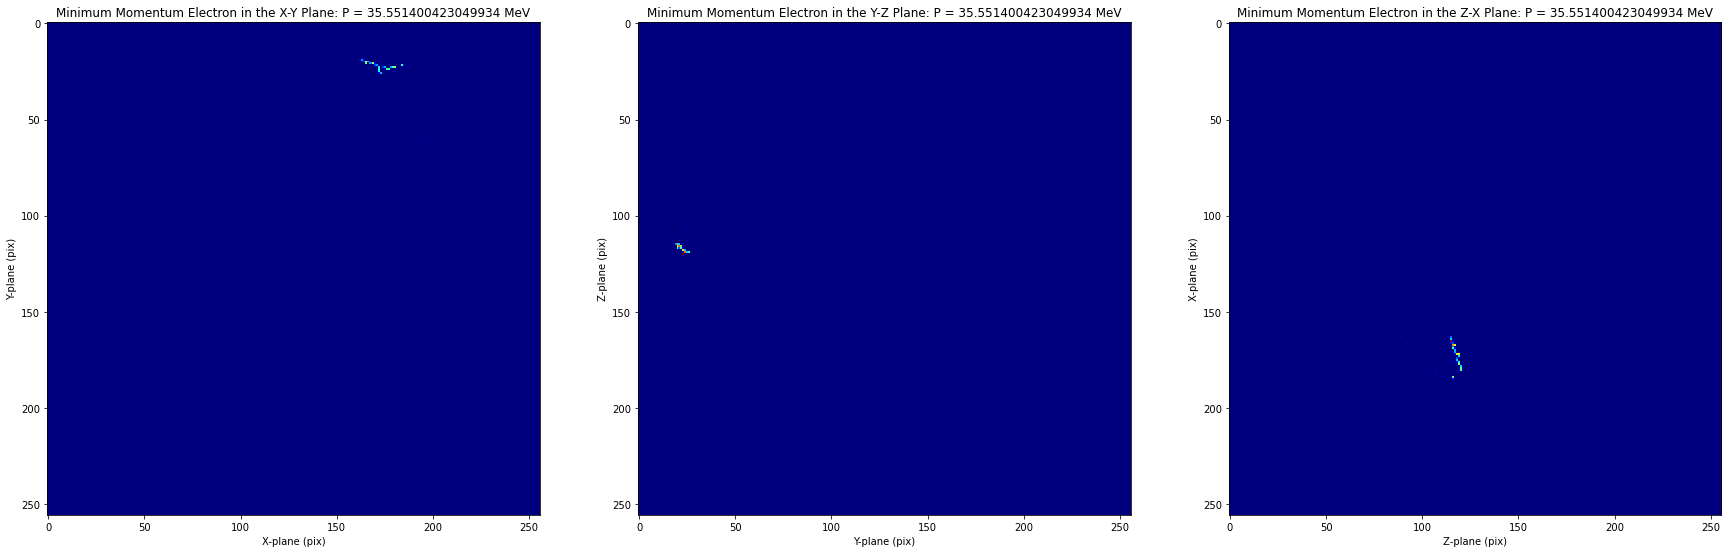

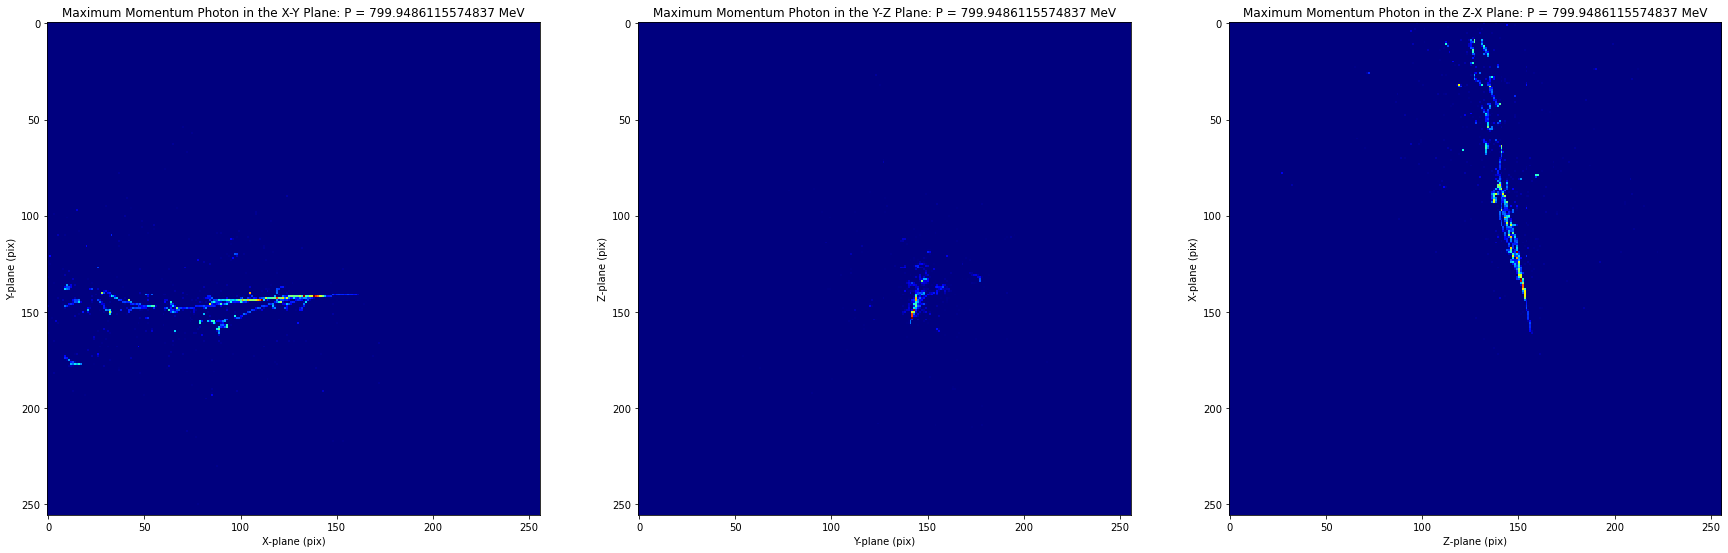

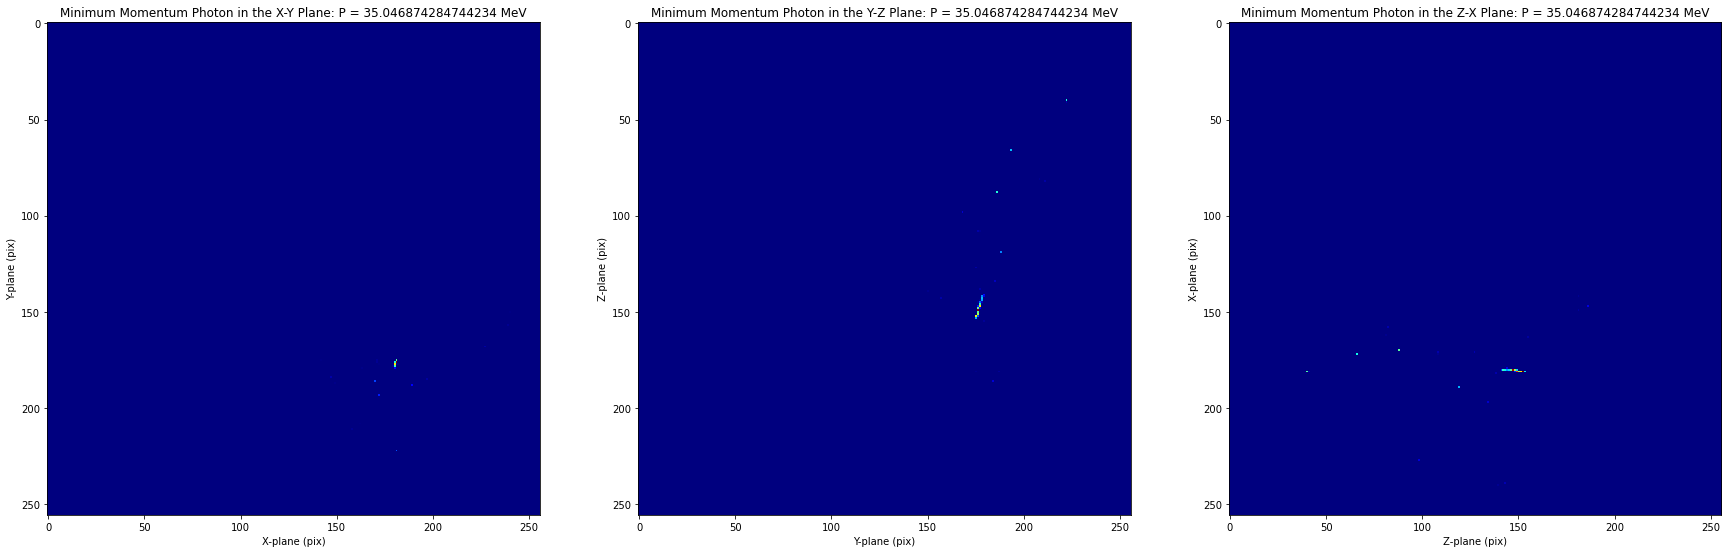

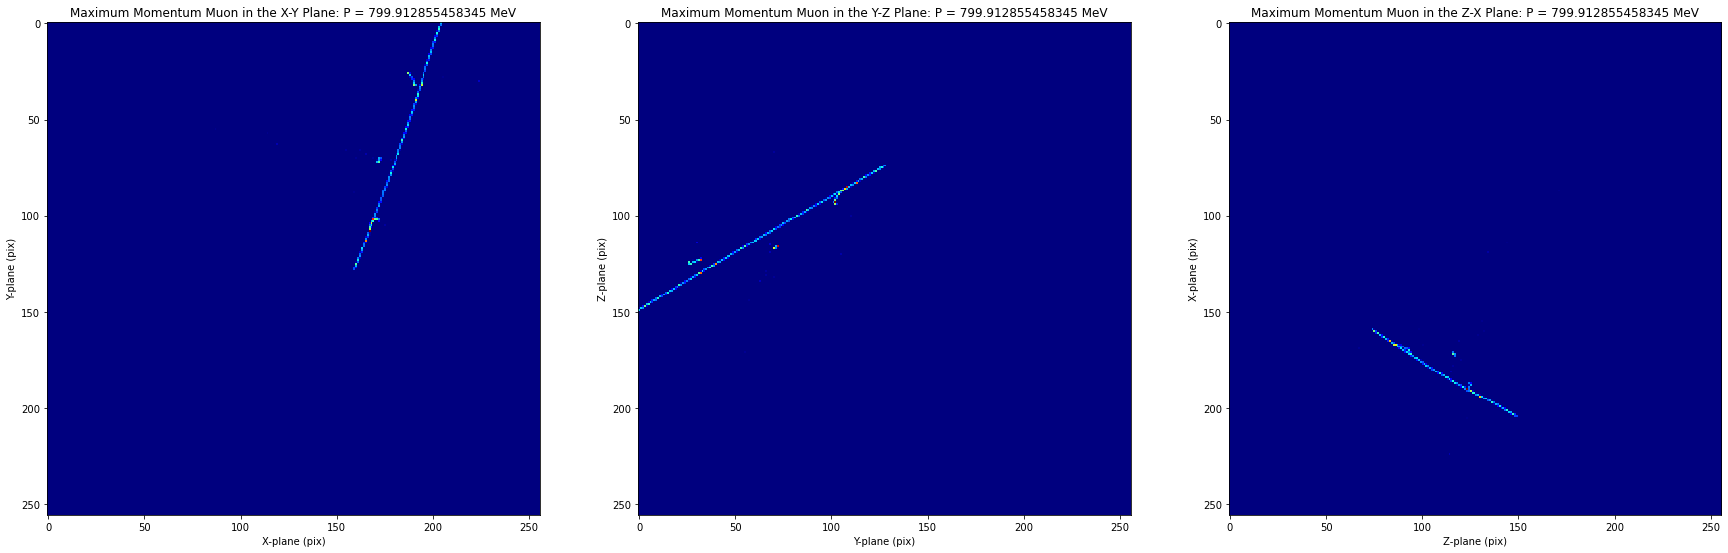

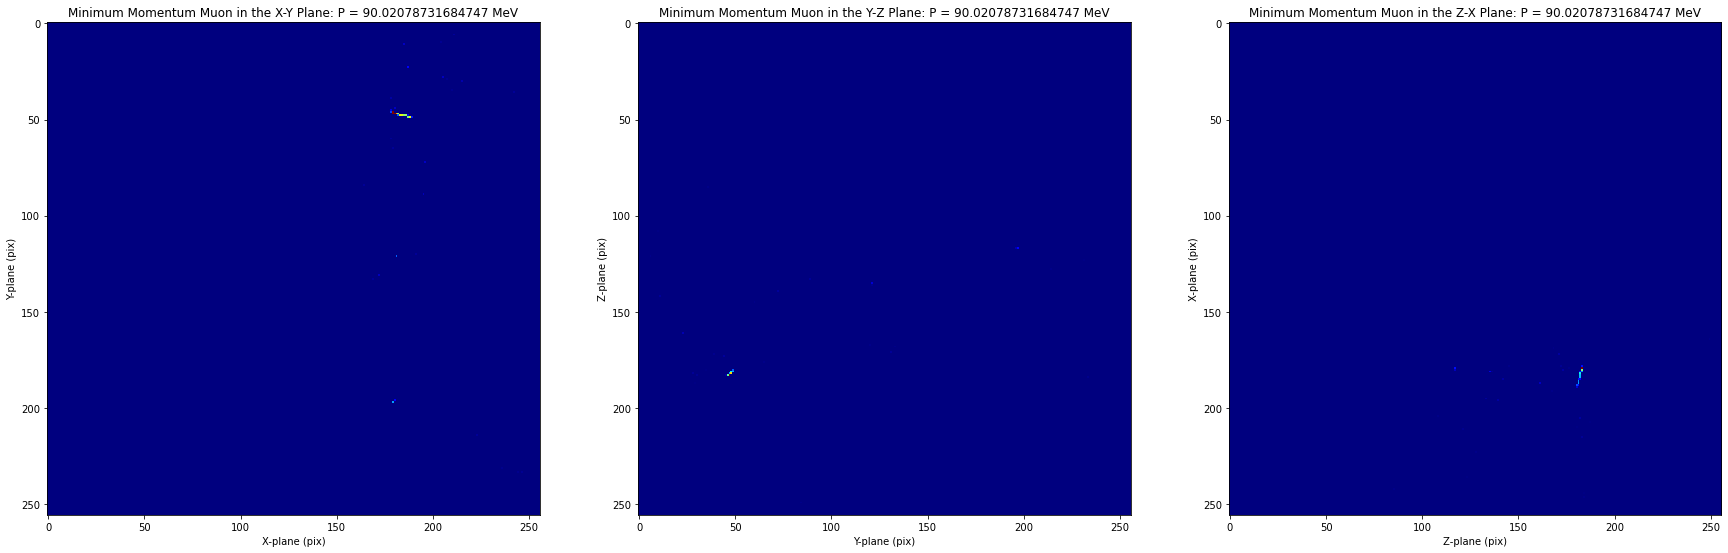

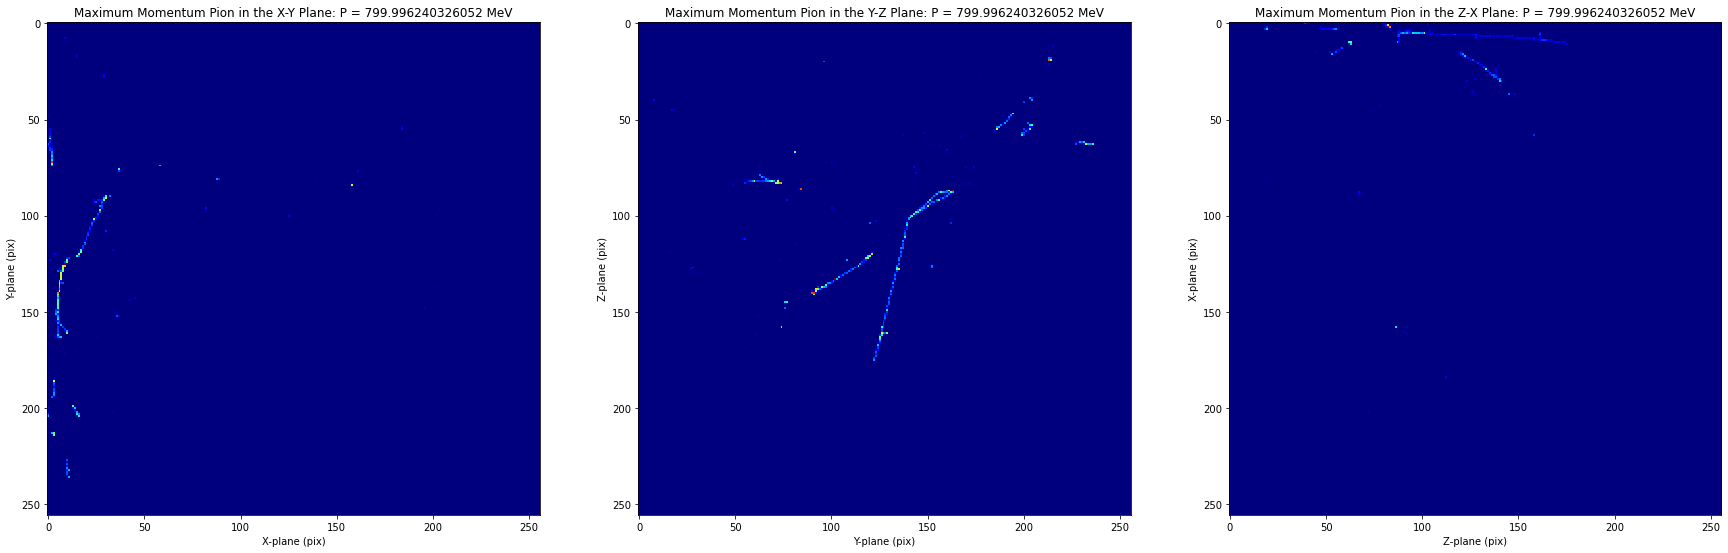

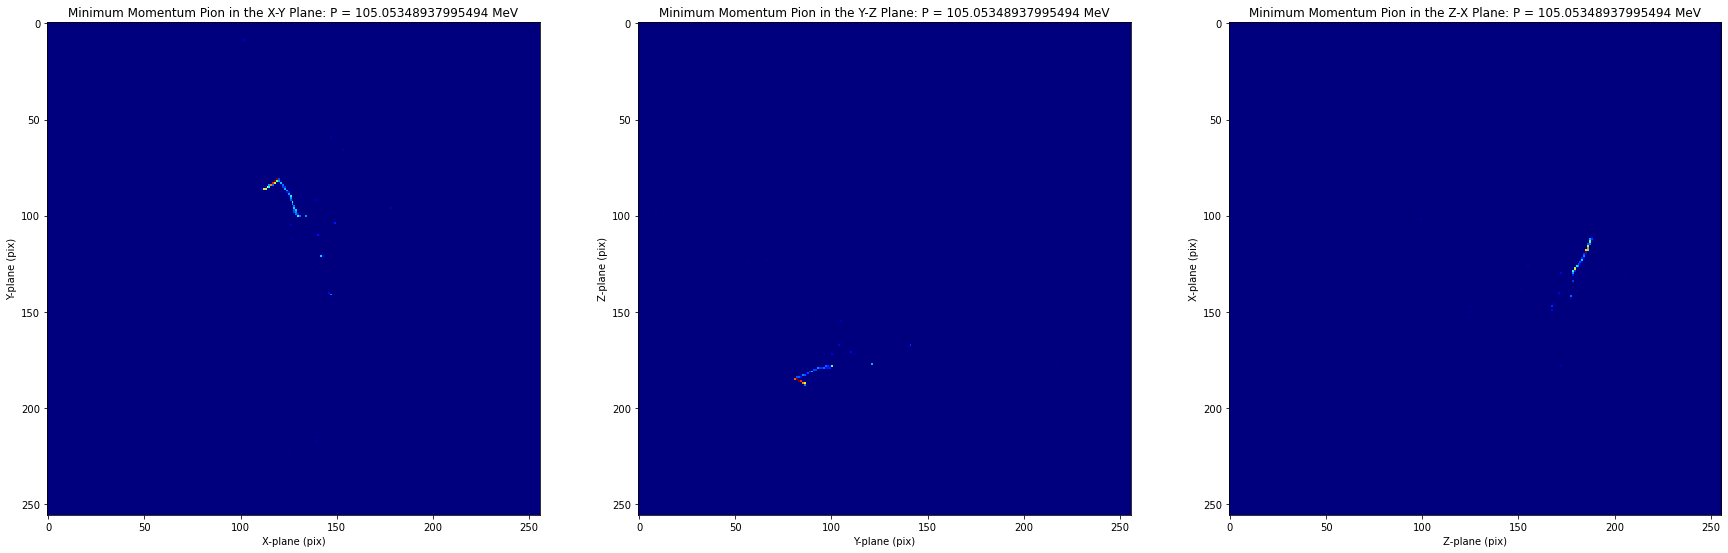

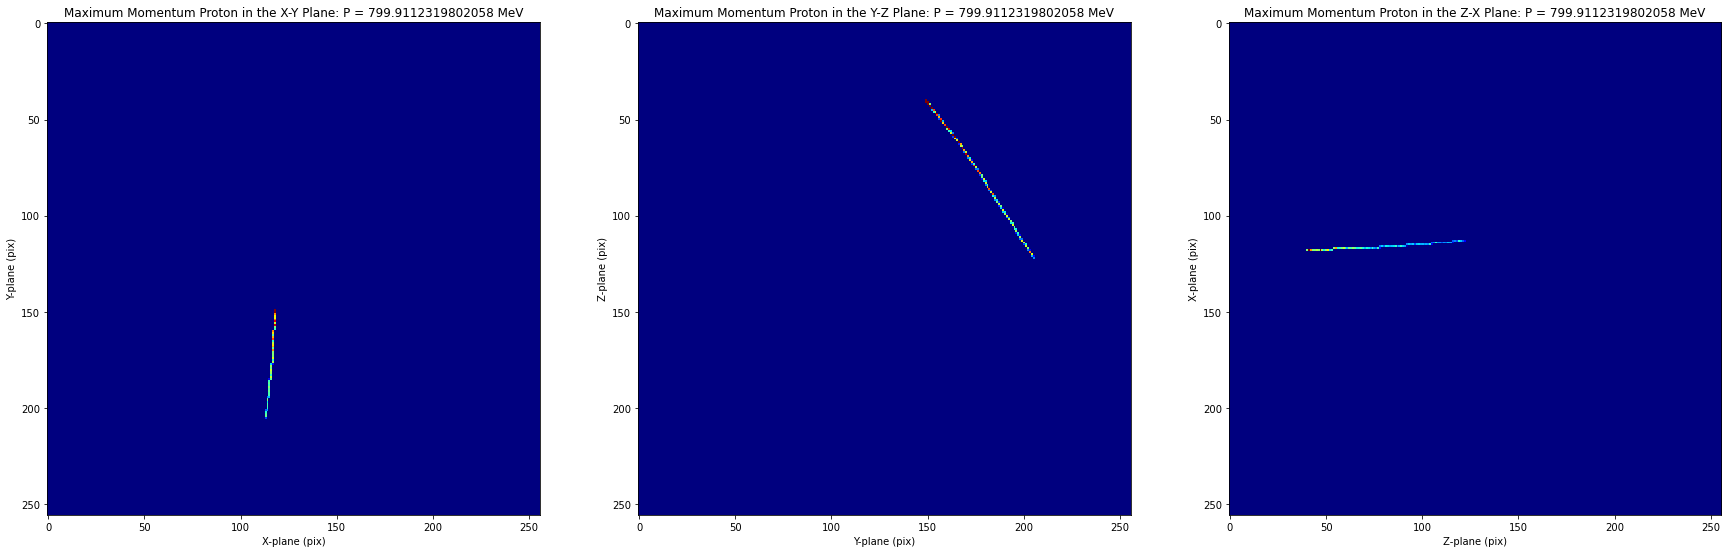

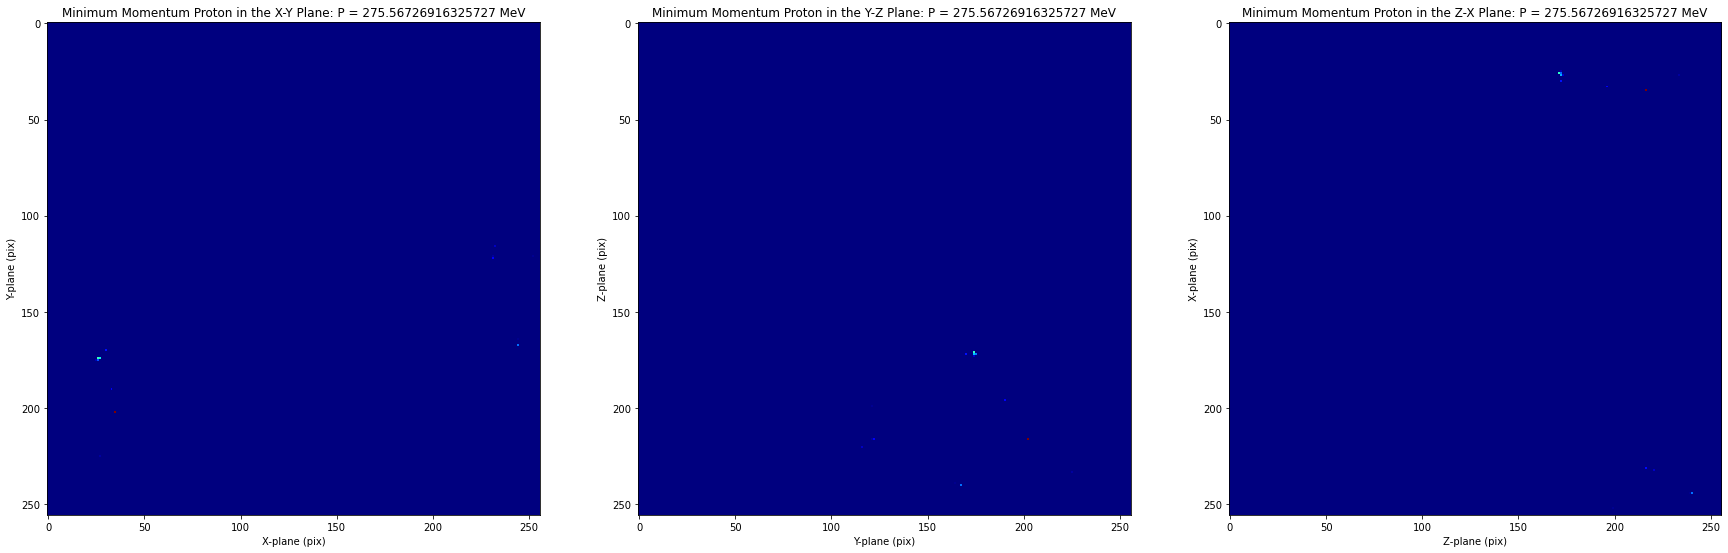

In [16]:
#Task 0 -- plotting for different momenta
p_codes = [11,22,13,211,2212]



for i in range(len(particles)):
    maximum = int(np.argwhere(p_ptot == max(p_ptot[p_id==p_codes[i]]))) # maximum momentum
    minimum = int(np.argwhere(p_ptot == min(p_ptot[p_id==p_codes[i]]))) # minimum momentum

    labels=["X-Y","Y-Z","Z-X"]
    ilist= toimage(images[maximum])
    fig = plt.figure(figsize=(30,10))
    for index, image in enumerate(ilist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title("Maximum Momentum "+str(p_name[i])+" in the "+str(labels[index])+" Plane: P = "+str(p_ptot[maximum])+" MeV")
    
    
    mlist= toimage(images[minimum])
    fig2 = plt.figure(figsize=(30,10))
    for index, image in enumerate(mlist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title("Minimum Momentum " +str(p_name[i])+" in the "+str(labels[index])+" Plane: P = "+str(p_ptot[minimum])+" MeV")



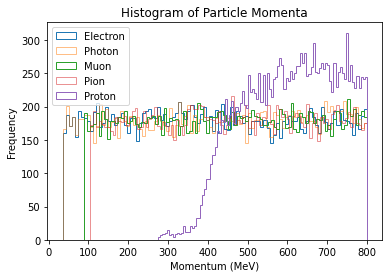

In [17]:
#Plotting histograms of the momentum distributions

alpha = [1,0.5,1,0.5,1]

for i in range(len(particles)):
    momentum = p_ptot[p_id == p_codes[i]]
    plt.hist(momentum,bins=100,label=p_name[i],histtype='step',stacked=True,fill=False,alpha=alpha[i])

plt.title("Histogram of Particle Momenta")
plt.xlabel("Momentum (MeV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Exploration of the Data

### Electron

The lowest momentum electron has a total momentum of 35 MeV. The images show a very small track of a single electron moving a short distance before stopping. This is in sharp contrast to the high momentum electron (800 MeV) which shows significant electromagnetic showering along with a long track. The histogram of particle momenta also shows that there is an even distribution of electron momenta with no bias towards either low or high momentum.

### Photon

Similar to the electron, the low energy photon also produces a small track before being absorbed as the showering induced by it is very limited and the products are of low energy. The high energy photon then produces a longer track and induces significantly more EM showering than the low energy one. Also notice that these showers are relatively narrow (especially the photon one) which is characteristic of electromagnetic induced showers. Like the electron, photons also have an even distribution of momentum according to the histogram.

### Muon

Again, the minimum energy track isn't particularly interesting as it's identical to the previous ones, although it is interesting to note it has a momentum of 90 GeV. A muon requires a larger amount of energy than an electron or photon to make a signal due to its much greater mass (106 MeV). The high energy track, however, is simply a straight line with little to no showering. Muons have high penetrating power as the brehmsstrahlung energy loss is proportional to $m^{-4}$ so at an energy of 800 MeV, brehmsstrahlung is virtually absent. There does appear to be some delta electron interaction at some spots but the majority is just a straight line. Finally, the histogram also shows that the momenta are evenly distributed meaning there are no hidden biases in the data

### Pion

The low momentum pion also produces a small track but this once bends abruptly to one side implying that it does scatter once with a nucleus. Again, like the muon, its lowest momentum is 105 MeV which is necessary for visible interactions to occur due to its higher mass (140 MeV). The high momentum pion, on the other hand, induces a wide hadronic shower that spans the whole space. The tracks seem to appear from nowhere which I presume are $\pi^0$ decaying into charged muons which then show up. Scattering can also be seen in the Y-Z plane. Like the other particles above, the histogram reveals a consistent momentum distrubution.

### Proton

The low momentum proton produces a very small track (basically just a dot) which is expected considering its energy is 275 MeV (less than 1/3 its rest mass) so it has very little energy to transfer. This also explains why the 800 MeV "high" momentum proton also produces a straight line rather than showers. It is a strong line, however, (as in, it has a lot of red spots) meaning it is a good ioniser. Unlike the previous particles, the proton does show a bias towards higher momenta; namely, momenta between 300-500 MeV are underrepresented in the data set compared to the higher momenta. 

### What this Means for the Neural Network

The neural network will likely have difficulty in distinguishing between photons and electrons as they both shower in similar fashion (EM Shower) and have similar energies. On top of this, because they both shower virtually instantly (or produce very short tracks, depending on their energy), they essentially become the same things once the image is produced. The only difference being that the electron shows a short bright beam before showering whereas the photon, which is less ionising, only becomes truly visible once it showers into more ionizing charged particles. Because of this, although technically possible to differentiate between the two, the neural network will have huge difficulty in distinguishing these particles.

The muon produces long straight lines that very rarely give off further ionizing particles, which should make it very easy to separate between them and other particles. At low momenta, however, they do have some very similar characteristics with the other particles as they produce short, single, tracks. Therefore, at the highest energies, the muons should be easily recognised by the neural network although at low energies it will likely be confused between them and the other particles that produce short, single, tracks at low energies: the pion and the proton. 

The pion and the proton produce hadronic showers which should appear differently in Argon time projection chambers, as hadronic showers tend to be wider and more extravagant than EM showers. Therefore, when these particles do shower, it is expected that the neural network will detect the difference between these two particles and the other ones. Protons will likely be the easiest to detect as the histogram shows their momentum distribution is biased towards the high energies, meaning the majority of them shower (rather than appearing as 'dots'). This means that the protons will likely be the easiest to distinguish and electrons & photons the hardest to distinguish.  


## Task 1


In [18]:
# Preamble for setting up the neural network (NN)
# NN outputs are numbers between 0-4 so the labels should be converted
# from 11, 22 etc. to numbers between 0-4


y_labels = []
y_labels_test = []
for i in truth_train[:,0]: # Looping over the training data
    if i == 11:
        y_labels.append(0)
    elif i == 22:
        y_labels.append(1)
    elif i == 13:
        y_labels.append(2)
    elif i == 211:
        y_labels.append(3)
    elif i == 2212:
        y_labels.append(4)
        
for i in truth_test[:,0]: # Looping over the testing data
    if i == 11:
        y_labels_test.append(0)
    elif i == 22:
        y_labels_test.append(1)
    elif i == 13:
        y_labels_test.append(2)
    elif i == 211:
        y_labels_test.append(3)
    elif i == 2212:
        y_labels_test.append(4)

# These must be arrays rather than lists to remove errors
y_labels=np.asarray(y_labels)
y_labels_test=np.asarray(y_labels_test)

In [25]:
#Task 1 -- Hyperparameter Search

from sklearn.model_selection import ParameterGrid
tf.compat.v1.experimental.output_all_intermediates(True) # Include this to allow dropout layers to work

hyper_history = {} #Create empty dictionary that fills up with the keras values

#Define the testing parameters
parameters = {"conv":[[24,12,6,3],[24,16,12,8],[4,8,12,16]],
             "dense": [[20,10],[10],[50,25]],
             "dropout": [[0.1,0.1],[0.2,0.2],[0.4,0.4]]}

# Create a grid of all possible combinations
grid = list(ParameterGrid(parameters))

# Use 10% validation and batch size of 32
validation_slice=5000
batch_size=32 

# Reduce learning rate after 2 epochs of no val_loss improvement
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

# Stop the training after 4 epochs of no val_loss improvement
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)

def make_model(g):
    """This function creates a model based on the hyperparameter inputs"""
    
    drop = g['dropout']
    conv = g['conv']
    dense = g['dense']
    
    inp = Input(shape=256*256*3) #Input is one dimensional array with size equal to the images
    inp_reshape = Reshape((256,256,3))(inp) # Reshaping back to an image
    conv1 = Conv2D(conv[0],(3,3),activation='relu')(inp_reshape) 
    conv2 = Conv2D(conv[1],(3,3),activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv2) # Place a pooling between 2 convolutional layers
    drop1 = Dropout(drop[0])(pool1) # Place a dropout layer after every pool to reduce overtraining
    conv3 = Conv2D(conv[2],(3,3),activation='relu')(drop1) 
    conv4 = Conv2D(conv[3],(3,3),activation='relu')(conv3) 
    pool2 = MaxPooling2D(pool_size=(2,2))(conv4)  
    drop2 = Dropout(drop[1])(pool2)
    flat = Flatten()(drop2) # Flatten the output to feed it into the dense layers
    if len(dense) == 2:
        hidden1 = Dense(dense[0], activation='relu')(flat) 
        hidden2 = Dense(dense[1], activation='relu')(hidden1)
        output = Dense(5, activation='softmax')(hidden2) 
    else:
        hidden = Dense(dense[0], activation='relu')(flat) 
        output = Dense(5, activation='softmax')(hidden)
        # Use softmax activation function to categorise to 5 different particle types
        
    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer='Adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
    return model
    
    

# This for loop fits all the hyperparameter conbinations and saves their history in a dictionary
for i in range(len(grid)):
    hyper = make_model(grid[i])
    hyper.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size),
                      epochs=1,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-validation_slice:], y_labels[-validation_slice:]),callbacks=[reduce_lr,early])
    hyper_history["combination "+str(i+1)] = hyper.history

#hyper_history['combination 1'].history        

{'loss': [1.6235002243671444],
 'accuracy': [0.20012447],
 'val_loss': [1.6098060516794777],
 'val_accuracy': [0.1982],
 'lr': [0.001]}

Note: Unfortunately, due to the fact this took too long to run, I was unable to complete the hyper parameter search. This code does work fully, however, and to prove it I have included an output of a single epoch. You would simply plot these as hyper_history['combination n'].history['loss'], look at the loss functions and look for the line with the lowest loss function and the least amount of overtraining (low val_loss relative to loss). The parameters corresponding to this would be the ideal architecture.

In [18]:
# Using CNN to identify the images

# This architecture appears to be the best choice for speed and quality.
# It's based on the same architecture as that of the hyperparameter search

inp = Input(shape=256*256*3) 
inp_reshape = Reshape((256,256,3))(inp) 
conv1 = Conv2D(4,(3,3),activation='relu')(inp_reshape) 
conv2 = Conv2D(8,(3,3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2) 
drop1 = Dropout(0.2)(pool1)
conv3 = Conv2D(12,(3,3),activation='relu')(drop1) 
conv4 = Conv2D(16,(3,3),activation='relu')(conv3) 
pool2 = MaxPooling2D(pool_size=(2,2))(conv4)  
drop2 = Dropout(0.2)(pool2)
flat = Flatten()(drop2) 
hidden1 = Dense(20, activation='relu')(flat) 
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(5, activation='softmax')(hidden2) 
model = Model(inputs=inp, outputs=output)


model.compile(optimizer='Adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 4)       112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 8)       296       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 12)      876   

A convolutional neural network is used because the input has over 190,000 values which then gets pooled to reduce the size before being flattened. This is to allow it to enter a hidden dense layer which brings it to an output with 5 nodes. Each of these 5 nodes correspond to a particle type and they output a probability of it being that particle. In addition, dropout layers have been added after each pooling layer to reduce overtraining.  

This model has over a million trainable parameters which is quite a lot, although it is to be expected for around 60000 parameters going into a dense layer of 20 nodes. The model takes around 15 minutes to run per epoch on my laptop (same time as on the university computers).

In [20]:
# Save the model with the highest val_accuracy after training ends 
checkpoint = ModelCheckpoint(
    filepath='checkpoint_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-validation_slice:], y_labels[-validation_slice:]),callbacks=[reduce_lr,early,checkpoint])

In [21]:
model.save("Model_3.h5") #save the model for later use

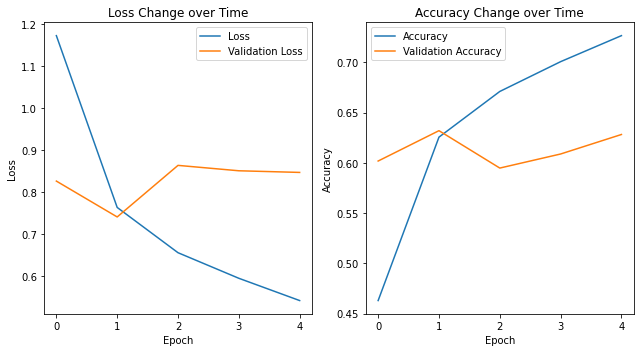

In [22]:
#Plotting the loss curves

fig,ax = plt.subplots(1,2,figsize=(9,5))
ax[0].plot(history.history['loss'],label='Loss')
ax[0].plot(history.history['val_loss'],label='Validation Loss')
ax[0].set_title("Loss Change over Time")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history['accuracy'],label='Accuracy')
ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
ax[1].set_title("Accuracy Change over Time")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

These loss curves aren't too bad as they show a general decrease (except for a sharp increase in epoch 2), although the early stopping mechanism appears to have stopped the training too early as the loss was still decreasing. The validation accuracy is also quite good as it reaches an accuracy of around 62% which is much better than random chance (which would give 20% accuracy) so the model certainly works and did not overtrain.

In [19]:
model = load_model('Model_3.h5')

prediction = np.argmax(model.predict(x_test[:5000]),axis=1) # Only test 5000 as I don't have the memory for all of it :(

C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


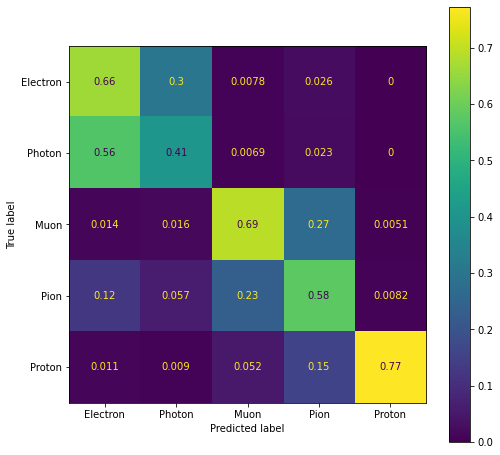

In [20]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(8, 8))
#Define the confusion matrix and normalise it so that each row/column sums to 1
cmat = confusion_matrix(y_labels_test[:5000],prediction,normalize='true')
#dispay the matrix and redefine the display labels to show the weather type
cmatplot = ConfusionMatrixDisplay(confusion_matrix=cmat,display_labels=p_name)

cmatplot.plot(ax=ax)
plt.show()

The confusion matrix shows that the ability of the model to differentiate between electrons and photons is terrible. Despite getting electrons correct 66% of the time, the fact that it identifies 56% of all photons as electrons means this is nothing more than an artifact from the over predicting of electrons. This is further supported by the fact that it only guesses photons correctly 41% of the time and only 30% of photons are misrepresented as electrons. In fact, the model shows an almost complete inability to differentiate between the two. Although it is very good at differentiating them from the other particles.

More positively, it is quite good at finding protons as it gets that right 77% of them time and only confuses them with pions which is likely caused by the hadronic showering being quite similar at high pion energies. Strangely, the inverse doesn't hold true so it could that the model assumes all hadronic showering is caused by protons. Regarding pions, the model appears to confuse them with muons & electrons quite often. This isn't as was predicted although the image in cell 15 (the first one written by me) does show the muon and pion looking virtually identical. Therefore, it appears that pions which do not shower trick the model into believing they are muons. This is supported by the fact that, for muons, the same holds true as many real muons are misclassified as pions.

Thus, the model appears to be very good at differentiating particles into three categories: electrons & photons, muons & pions, and protons.

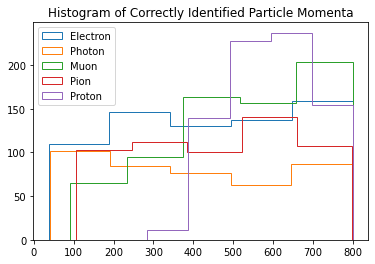

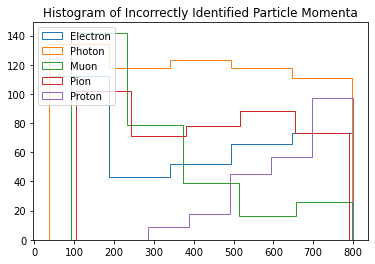

In [21]:
#Comparing which are right and wrong and trying to find a pattern

#An array of all the correct positions
correct_positions = [] 

#An array of all the incorrect positions
incorrect_positions = []

#filling up the lists
for i in range(len(prediction)):
    if prediction[i] == y_labels_test[i]:
        correct_positions.append(i)
    else:
        incorrect_positions.append(i)
        
#Comparing momenta distribution between right and wrong

for i in range(len(particles)):
    momentum=[]
    for j in correct_positions:
        if truth_test[j][0] == p_codes[i]:
            momentum.append(truth_test[j][1])
    plt.hist(momentum,bins=5,label=p_name[i],histtype='step',stacked=True,fill=False)
    
plt.title("Histogram of Correctly Identified Particle Momenta")
plt.legend()
plt.show()

for i in range(len(particles)):
    momentum=[]
    for j in incorrect_positions:
        if truth_test[j][0] == p_codes[i]:
            momentum.append(truth_test[j][1])
    plt.hist(momentum,bins=5,label=p_name[i],histtype='step',stacked=True,fill=False)

plt.title("Histogram of Incorrectly Identified Particle Momenta")
plt.legend()
plt.show()

Looking at these histograms, it appears there is no momentum bias for pion identification (red line is relatively flat) and there also isn't one for photons. For electrons, however, the model appears to make more errors with low energy electrons than with high energy ones. This is likely due to the fact that low energy electrons look similar to photons which the model mislabels. 

Furthermore, there is a strange tendency for the model to mislabel high energy protons as the number of correctly identified protons (purple line in top graph) decreases sharply at energies higher than 700 MeV. This is completely at odds with the earlier prediction but, considering 15% of all protons are seen as pions, it is possible that the model has been led to classify all big hadronic showers as high energy pions rather than protons. 

Finally, the most striking pattern is that low momentum muons are considerably more likely to be misclassified at low momentum than high momentum. This must mean that low energy muons, which do not exhibit any delta electron production, are being confused for pions which would explain the 27% pion appearance in the confusion matrix. The model can then probably detect the distinct lack of showering along with the small lines coming off of the track and classify it as a muon. 

Thus, with this information, we can make cuts to the data to improve model performance. These include:

- removing electrons with momentum below 200 MeV
- removing muons with momentum below 400 MeV
- removing protons with momentum above 700 MeV

In [42]:
# Making the cuts on electrons, protons and muons
five_x_test = x_test[:5000]
five_truth_test = truth_test[:5000]
cut_x_test = []
cut_labels = []

for i in range(5000):
    if five_truth_test[i,0] == 11 and five_truth_test[i,1] < 200: # remove electrons with energy < 200 MeV
        pass
    elif five_truth_test[i,0] == 13 and five_truth_test[i,1] < 400: # remove muons with energy < 400 MeV 
        pass
    elif five_truth_test[i,0] == 2212 and five_truth_test[i,1] > 700: # remove protons with energy > 700 MeV
        pass
    else:
        cut_x_test.append(five_x_test[i])
        cut_labels.append(y_labels_test[i])
    
    
#Turn these into numpy arrays to remove errors

cut_x_test = np.asarray(cut_x_test)
cut_labels = np.asarray(cut_labels)

In [43]:
# This function is required as the NN doesn't accept lists or arrays -- only a single sparse matrix
def stacking_generator(train,test):
    """This function converts an array of sparse matrices to a single sparse csr matrix"""
    stacking_list_train=[]
    stacking_list_test=[]
    for i in range(len(train)):
        stacking_list_train.append(train[i])
    for j in range(len(test)):
        stacking_list_test.append(test[j])
    new_train = sparse.vstack(stacking_list_train)
    new_test = sparse.vstack(stacking_list_test)
    return new_train,new_test

In [44]:
# Only need the testing dataset
cut_x_test, trash = stacking_generator(cut_x_test, cut_x_test[:2])

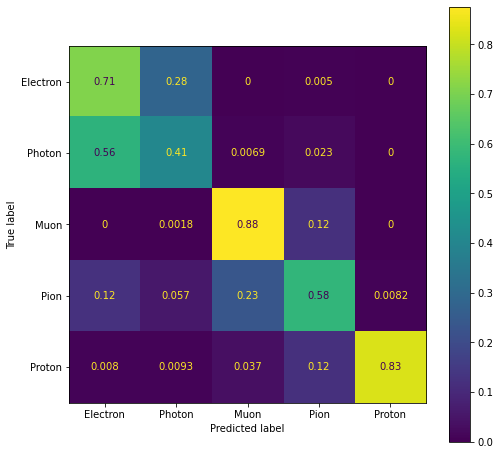

In [45]:
#Plotting confusion matrix of cut data analysis
new_prediction = np.argmax(model.predict(cut_x_test),axis=1)

fig,ax = plt.subplots(figsize=(8, 8))
#Define the confusion matrix and normalise it so that each row/column sums to 1
cmat = confusion_matrix(cut_labels,new_prediction,normalize='true')
#dispay the matrix and redefine the display labels to show the weather type
cmatplot = ConfusionMatrixDisplay(confusion_matrix=cmat,display_labels=p_name)

cmatplot.plot(ax=ax)
plt.show()

This confusion matrix is certainly better than the one before. The cuts have definitely made a difference as the protons have gone up from 77% accuracy to 83%, electrons have gone up from 66% to 71% whilst, most strikingly, the muon accuracy has gone up from 69% to 88% making them the best predicted particle!

It is therefore clear that low momentum muons were the achilles heel of the model, and that they were often confused with other particles. Now, the only confusion of muons is with pions (a few photons appear to have snuck in as well, however) meaning the neural network probably does look for long straight lines to classify as muons. The electrons haven't improved as much as hoped but it does seem likely that the very low energy ones, which don't shower much, contributed to the high peaks in the histogram. These are removed as the confusion between electrons and particles other than photons is virtually absent but the mislabeling was small, contributing the low increase in electron labeling.

Thus, it can be concluded that electrons are very difficult to separate from photons regardless of their energy, high energy muons are incredibly distinctive and lower energy protons are easier to distinguish than ones with momentum close to their rest mass.


## Task 2

In [21]:
#Task 2 -- Finding regression algorithm to predict particle momentum of electron

ra_input = Input(shape=256*256*3)
ra_inp_reshape = Reshape((256,256,3))(ra_input)
ra_conv1 = Conv2D(4,(3,3),activation='relu')(ra_inp_reshape) 
ra_conv2 = Conv2D(8,(3,3),activation='relu')(ra_conv1)
ra_pool1 = MaxPooling2D(pool_size=(2,2))(ra_conv2) 
ra_drop1 = Dropout(0.2)(ra_pool1)
ra_conv3 = Conv2D(12,(3,3),activation='relu')(ra_drop1) 
ra_conv4 = Conv2D(24,(3,3),activation='relu')(ra_conv3) 
ra_pool2 = MaxPooling2D(pool_size=(2,2))(ra_conv4)  
ra_drop2 = Dropout(0.2)(ra_pool2)
ra_flat = Flatten()(ra_drop2) 
ra_hidden1 = Dense(20, activation='relu')(ra_flat) 
ra_hidden2 = Dense(10, activation='relu')(ra_hidden1)
ra_output = Dense(1,activation='relu')(ra_hidden2)

ra = Model(inputs=ra_input, outputs=ra_output)





ra.compile(optimizer='Adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
ra.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 254, 254, 4)       112       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 252, 252, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 8)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 126, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 12)      876 

A convoluted neural network is used in this regression as we're still dealing with a very large input so a network similar to the one before was used. The main differences are that the convolutional layers are a little larger, as the model runs faster, and the relu activation function was used, as the output layer has only one node. On top of this, the model was compiled with the mean squared error as the loss function as we're not categorising the particles but trying to predict their momentum. Therefore, it is best to minimise the difference between the predicted and actual momentum with the mean squared error.

In [22]:
#This cell takes only the electron images from the dataset and adds it to a list
images_e = []
truth_e = []
for i in np.where(p_id==11)[0]:
    images_e.append(images[i])
    truth_e.append(truth[i])
    
#Turn these into numpy arrays to remove errors
images_e = np.asarray(images_e)
truth_e = np.asarray(truth_e)

In [23]:
#prepare the testing and training datasets
x_train_e, x_test_e, truth_train_e, truth_test_e = train_test_split(images_e,truth_e,train_size=12000,random_state=11)

In [25]:
#This is required as the neural network only takes in a single csr matrix, rather than an array of csr matrices
x_train_e,x_test_e=stacking_generator(x_train_e,x_test_e)

In [26]:
val_slice = 1200 #10% validation
batch_size=32

#Checkpoint saves the model with minimum validation mean squared error
checkpoint2 = ModelCheckpoint(
    filepath='checkpoint_ra2.h5',
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)


momentum_train_e = truth_train_e[:,1] # take out the momentum data from the truth data
ra.fit(nn_batch_generator(x_train_e[:-val_slice],momentum_train_e[:-val_slice],batch_size),
                      epochs=20,
                      steps_per_epoch=int((12000-val_slice)/batch_size),
                      validation_data=(x_train_e[-val_slice:], momentum_train_e[-val_slice:]),callbacks=[reduce_lr,early,checkpoint2])

Epoch 1/20
337/337 [==============================] - ETA: 0s - batch: 168.0000 - size: 32.0000 - loss: 9737.5618 - mean_squared_error: 9737.5674

C:\ProgramData\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


337/337 [==============================] - 241s 714ms/step - batch: 168.0000 - size: 32.0000 - loss: 9737.5618 - mean_squared_error: 9737.5674 - val_loss: 18537.0098 - val_mean_squared_error: 18469.8984 - lr: 0.0010
Epoch 2/20
337/337 [==============================] - 243s 722ms/step - batch: 168.0000 - size: 31.9525 - loss: 5401.9655 - mean_squared_error: 5392.4478 - val_loss: 17783.1058 - val_mean_squared_error: 17682.5957 - lr: 0.0010
Epoch 3/20
337/337 [==============================] - 240s 711ms/step - batch: 168.0000 - size: 31.9525 - loss: 4526.2860 - mean_squared_error: 4522.5234 - val_loss: 8577.1294 - val_mean_squared_error: 8475.5947 - lr: 0.0010
Epoch 4/20
337/337 [==============================] - 239s 710ms/step - batch: 168.0000 - size: 31.9525 - loss: 4266.3946 - mean_squared_error: 4267.7104 - val_loss: 14307.6198 - val_mean_squared_error: 14181.6621 - lr: 0.0010
Epoch 5/20
337/337 [==============================] - 235s 697ms/step - batch: 168.0000 - size: 31.9525 -

In [27]:
#ra.save("ra_4.h5")
ra = load_model("checkpoint_ra2.h5")

In [28]:
ra_pred = ra.predict(x_test_e[:5000]) # Like above, RAM can only handle 5000 images

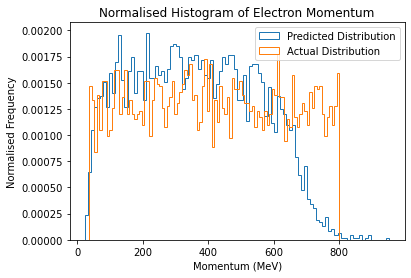

In [29]:
momentum_test_e = truth_test_e[:,1]

plt.hist(ra_pred,bins=100,fill=False,histtype='step',density=True,label='Predicted Distribution')
plt.hist(momentum_test_e[:5000],bins=100,fill=False,histtype='step',density=True,label='Actual Distribution')
plt.title("Normalised Histogram of Electron Momentum")
plt.xlabel('Momentum (MeV)')
plt.ylabel('Normalised Frequency')
plt.legend()
plt.show()

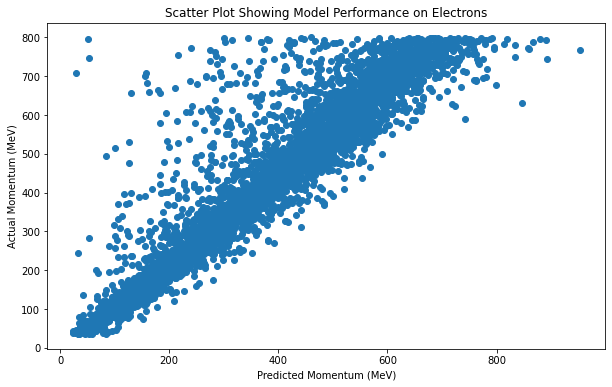

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(ra_pred,momentum_test_e[:5000])
plt.title("Scatter Plot Showing Model Performance on Electrons")
plt.xlabel("Predicted Momentum (MeV)")
plt.ylabel("Actual Momentum (MeV)")
plt.show()

Looking at the plot above, the linear regression is pretty good -- especially for low energies -- as there is a clear line with the majority of the spread caused by a few isolated points on the outside. Peculiarly, the momenta are more often predicted too low rather than too high. The histogram supports this as the number of electrons predicted to have energies greater than 600 MeV drops off quite quickly even though the dataset is even. The reason for this could be because that at high energies, the electron showers quicker. In other words, at low energies, the electron track keeps getting longer so the model uses single track length as a gauge to determine momentum. At high energies, however, the single track length no longer increases but actually decreases at it showers much faster which could account for the high momentum electrons being predicted as having a lower momentum than they actually do.

Furthermore, the histogram shows that the model did predict some momenta as being higher than the highest possible momentum of the dataset which means it hasn't recognised a hard cut-off limit.  

In [31]:
# Trying photon data on electron model
# Doing the exact same thing here as above but with photons instead


images_p = []
truth_p = []
for i in np.where(p_id==22)[0]:
    images_p.append(images[i])
    truth_p.append(truth[i])
    

images_p = np.asarray(images_p)
truth_p = np.asarray(truth_p)

# Only need testing dataset
photons,trash = stacking_generator(images_p[:5000],images_p[:2])

ra_photon_pred = ra.predict(photons)

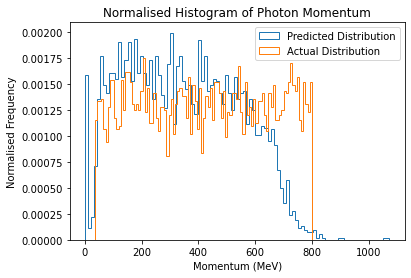

In [32]:
momentum_test_p = truth_p[:5000,1]

plt.hist(ra_photon_pred,bins=100,fill=False,histtype='step',density=True,label='Predicted Distribution')
plt.hist(momentum_test_p,bins=100,fill=False,histtype='step',density=True,label='Actual Distribution')
plt.title("Normalised Histogram of Photon Momentum")
plt.xlabel('Momentum (MeV)')
plt.ylabel('Normalised Frequency')
plt.legend()
plt.show()

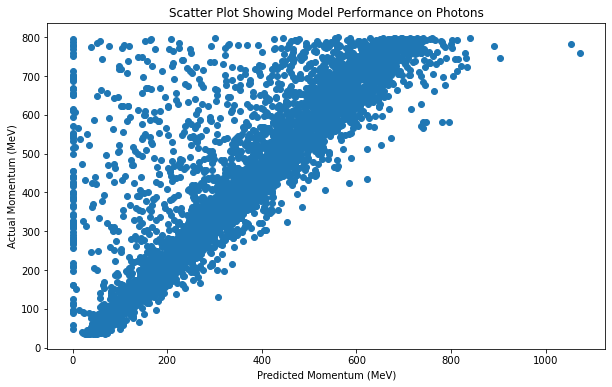

In [33]:
plt.figure(figsize=(10,6))
plt.scatter(ra_photon_pred,momentum_test_p)
plt.title("Scatter Plot Showing Model Performance on Photons")
plt.xlabel("Predicted Momentum (MeV)")
plt.ylabel("Actual Momentum (MeV)")
plt.show()

For photons, the model seems to work quite well. This should not come as much of a surprise considering how similar they are to electrons, although there are still a few differences. The first difference is that the amount of incorrectly predicted photon momenta has increased as the central line is much thicker and there are more outliers on the far left of the bottom graph. The most unusual artifact is the line on the far left of the bottom plot which corresponds to photons being predicted with exactly 0 momentum. There is no relation between true momentum as all momenta are, more or less, evenly affected. I suspect these are caused by mislabeled images or, at the lower momentum, the photons being nothing more than undetecable dots. Why the electrons are unaffected is a mystery, however, so further investigation would have to be done to find the root cause. One other potential theory could be due to the fact that photons tend to be weak ionisers compared to electrons. Therefore, if we were to assume my theory of single track length as being the parameter used by the NN to predict momentum is correct, then these photons predicted at 0 MeV may have ionised the argon too weakly to be observed. Thus, the model assumed there was no track at all and labelled these as 0 MeV regardless of whether there was a shower or not. 

Other than this, the model works just as well for photons as electrons, as the histograms are virtually identical (except for a peak at 0 on the photon one) and the model also underpredicts momentum for photons as for electrons. I believe the reasons for this are identical as those for the electron.